## **Mount data directory**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks'

## **Load required Libraries**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

from tensorflow.keras.applications import resnet50
from tensorflow.keras import layers
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, BatchNormalization, Add, Lambda
from tensorflow.keras.models import Model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
data_dir = 'chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'images.npy', 'labels.npy', 'vgg16_model.h5']
['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [ ]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3884
['person540_bacteria_2271.jpeg', 'person540_bacteria_2272.jpeg', 'person540_bacteria_2273.jpeg', 'person540_virus_1070.jpeg', 'person541_bacteria_2274.jpeg']


In [ ]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1349
['IM-0530-0001.jpeg', 'IM-0531-0001-0001.jpeg', 'IM-0531-0001.jpeg', 'IM-0532-0001.jpeg', 'IM-0533-0001-0001.jpeg']


In [ ]:
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(256),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 5232
    Root location: chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3020, 0.2706, 0.2471],
         [0.0000, 0.0000, 0.0000,  ..., 0.2980, 0.2667, 0.2431],
         [0.0000, 0.0000, 0.0000,  ..., 0.2941, 0.2667, 0.2353]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3020, 0.2706, 0.2471],
         [0.0000, 0.0000, 0.0000,  ..., 0.2980, 0.2667, 0.2431],
         [0.0000, 0.0000, 0.0000,  ..., 0.2941, 0.2667, 0.2353]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [ ]:
print(dataset.classes)

['NORMAL', 'PNEUMONIA']


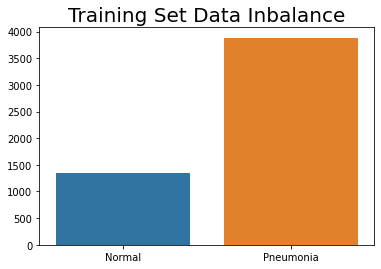

In [ ]:
# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

Label:  NORMAL (0)


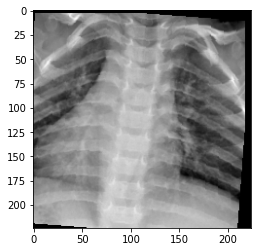

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[4])

In [ ]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

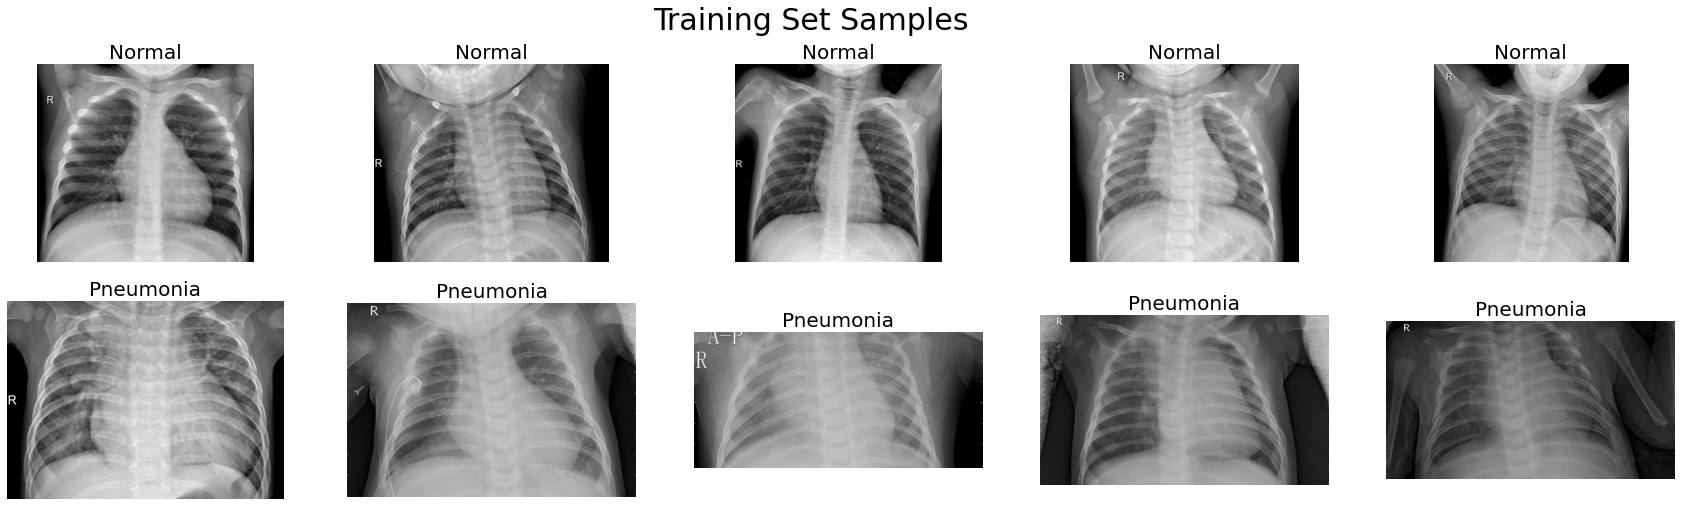

In [ ]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [ ]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

In [ ]:
train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3662, 1570)

In [ ]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

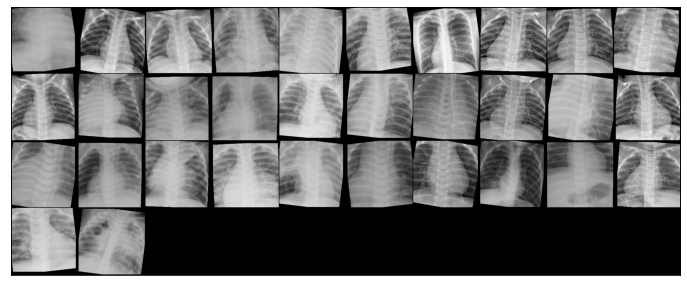

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

In [ ]:
class PneumoniaModelBase(nn.Module):
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)
    
#     def freeze(self):
#         # To freeze the residual layers
#         for param in self.network.parameters():
#             param.require_grad = False
#         for param in self.network.fc.parameters():
#             param.require_grad = True
    
#     def unfreeze(self):
#         # Unfreeze all layers
#         for param in self.network.parameters():
#             param.require_grad = True

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    
#    Set up cutom optimizer with weight decay
#    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

#     Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
#   sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients  
            # optimizer.cleargrads() 
            
#             Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 10:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

In [ ]:
epochs = 12
lr = 0.001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [ ]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

Epoch [1], train_loss: 0.2261, train_acc: 0.9125, val_loss: 0.1694, val_acc: 0.9356
Epoch [2], train_loss: 0.1447, train_acc: 0.9457, val_loss: 0.1481, val_acc: 0.9356
Epoch [3], train_loss: 0.1514, train_acc: 0.9378, val_loss: 0.1472, val_acc: 0.9426
Epoch [4], train_loss: 0.1232, train_acc: 0.9510, val_loss: 0.1400, val_acc: 0.9514
Epoch [5], train_loss: 0.1323, train_acc: 0.9481, val_loss: 0.0884, val_acc: 0.9645
Epoch [6], train_loss: 0.1098, train_acc: 0.9567, val_loss: 0.1622, val_acc: 0.9506
Epoch [7], train_loss: 0.1209, train_acc: 0.9548, val_loss: 0.2028, val_acc: 0.9328
Epoch [8], train_loss: 0.1134, train_acc: 0.9548, val_loss: 0.1035, val_acc: 0.9606
Epoch [9], train_loss: 0.0923, train_acc: 0.9652, val_loss: 0.1500, val_acc: 0.9415
Epoch [10], train_loss: 0.1220, train_acc: 0.9563, val_loss: 0.1204, val_acc: 0.9556
Epoch [11], train_loss: 0.1197, train_acc: 0.9556, val_loss: 0.1444, val_acc: 0.9394
Epoch [12], train_loss: 0.0879, train_acc: 0.9676, val_loss: 0.0653, val_a

In [ ]:
print('Best loss is:', best_loss)

Best loss is: 0.0652787983417511


In [ ]:
# Save Model
bestmodel = {'model': PneumoniaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

# torch.save(bestmodel, 'PneumoniaResnet_32_12.pth')
# torch.save_weights(bestmodel, 'PneumoniaResnet_weights.h5')
torch.save(bestmodel, 'PneumoniaResnet_32_12.bin')

In [ ]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('./PneumoniaResnet.pth')

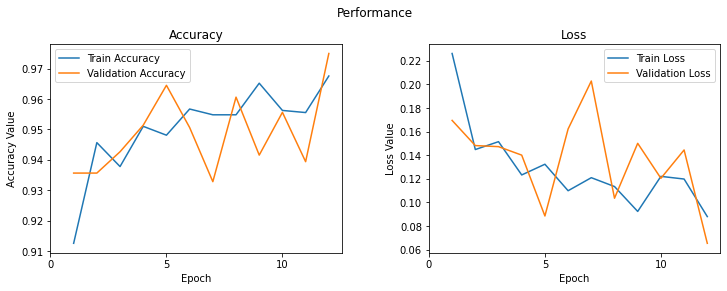

In [ ]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

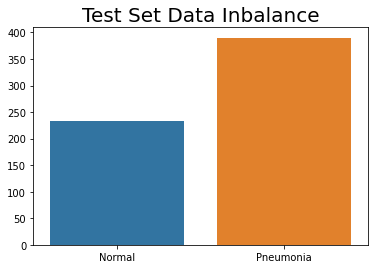

In [ ]:
# number of images for each class in test filder

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [ ]:
# Evaluate test set
test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.5431, test_acc: 0.8837


<Figure size 432x288 with 0 Axes>

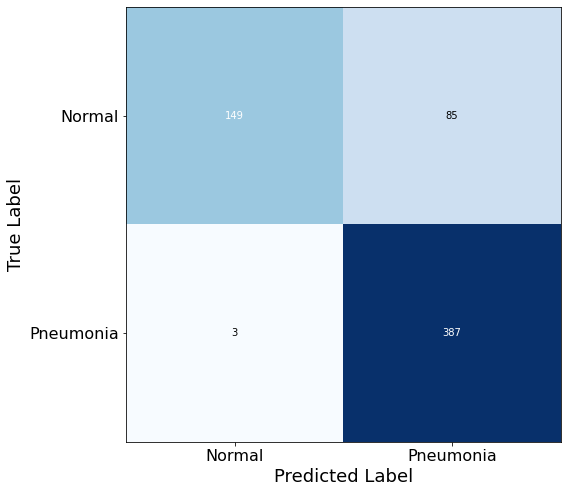

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.86
Recall of the model is 0.99
Precision of the model is 0.82
F1 Score of the model is 0.90


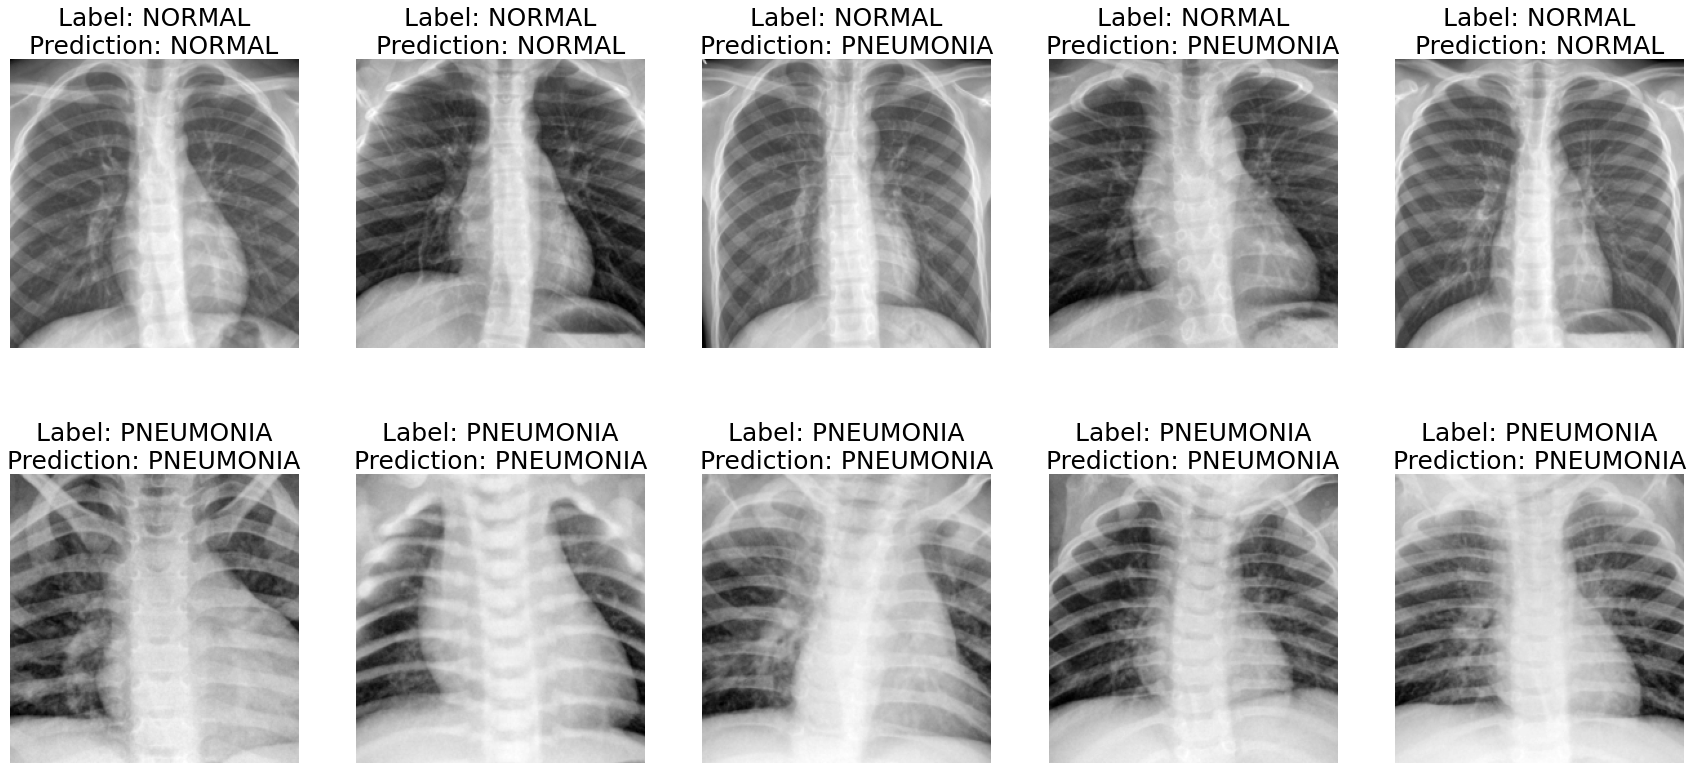

In [ ]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

## Visualizing with GradCam

In [ ]:
# load_checkpoint('PneumoniaResnet_32_12.pth')

In [ ]:
def get_img_array(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(config.img_size, config.img_size))
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Add one dimension to transform our array into a batch
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer = nn.Sequential(*list(model.children())[:-2])
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)
    
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def create_superimposed_visualization(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    
    return superimposed_img

In [ ]:
# We need to get the names of the last convolution layer of ResNet50
last_conv_layer_name = 'activation_80'

# We also need the names of all the layers that are part of the model head
classifier_layer_names = [
    'global_average_pooling2d_16',
    'dense'
]